<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/Trend_Country_Mapipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Run this cell first in Colab / notebook to install needed libs
!pip install -q pytrends geopandas pycountry pandas matplotlib plotly

In [8]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import pycountry
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import time
import re

# Output folders
OUT = Path("pytrends_subregion_outputs")
OUT.mkdir(exist_ok=True)
CSV_OUT = OUT / "csv"
IMG_OUT = OUT / "images"
CSV_OUT.mkdir(exist_ok=True)
IMG_OUT.mkdir(exist_ok=True)

# keywords and countries (ISO2)
KEYWORDS = ["matcha", "dubai_chocolate", "baked_feta_cheese_pasta", "air_fryer"]
COUNTRIES = ["IN","US","GB","AE","KR"]   # India, United States, United Kingdom, UAE, South Korea

# Pytrends connection (no auth required)
pytrends = TrendReq(hl='en-US', tz=360)

In [9]:
def fetch_pytrends_regions(keyword, country_iso2, timeframe='2015-01-01 2025-10-01', sleep=1.0):
    """
    Fetch region-level interest for `keyword` inside country `country_iso2` (ISO2 like 'IN').
    Returns:
      - region_ts_df: DataFrame indexed by date with columns=region names (if available)
      - region_scalar_df: DataFrame with columns ['iso_3166_2','region_name','value_mean'] mapped to region scalar
    Notes:
      - timeframe uses Google Trends timeframe syntax 'YYYY-MM-DD YYYY-MM-DD' or 'today 5-y'
      - pytrends returns aggregated interest_by_region for the keyword
    """
    kw = keyword.replace("_"," ")
    # build payload (single keyword)
    pytrends.build_payload([kw], cat=0, timeframe=timeframe, geo=country_iso2, gprop='')
    # interest by region: resolution='REGION' returns subnational regions
    try:
        reg = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=True)
    except Exception as e:
        # sometimes Google rate limits; wait and retry once
        print("pytrends error:", e, " — retrying after 5s")
        time.sleep(5)
        pytrends.build_payload([kw], timeframe=timeframe, geo=country_iso2)
        reg = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=True)

    if reg is None or reg.empty:
        return pd.DataFrame(), pd.DataFrame()

    # reg may have columns: 'geoCode' or 'geoName' depending on pytrends version
    reg = reg.reset_index()  # index is region name
    # attempt to find geo code column
    geo_col = next((c for c in reg.columns if c.lower() in ('geo_code','geocode','geoCode'.lower(), 'geo_code')), None)
    if geo_col is None:
        # pytrends sometimes has a column named 'geoCode' with mixed case
        geo_col = next((c for c in reg.columns if 'geo' in c.lower() and 'code' in c.lower()), None)
    # prepare scalar: mean across timeframe if reg holds timeseries? interest_by_region usually returns single column == kw
    # assume the column with the keyword (or the second numeric column) is the interest value
    numeric_cols = [c for c in reg.columns if reg[c].dtype.kind in 'fi']
    if not numeric_cols:
        # maybe reg contains only the index and geo codes; return empty
        return pd.DataFrame(), pd.DataFrame()

    value_col = numeric_cols[0]  # usually the kw column
    reg = reg.rename(columns={reg.columns[0]:'region_name'})  # first col is region name
    # If reg contains region-level timeseries? Usually interest_by_region returns single numeric per region
    # Create scalar (mean = value itself)
    reg['value_mean'] = pd.to_numeric(reg[value_col], errors='coerce')

    # Try to extract ISO-3166-2 code (pytrends sometimes returns geoCode like 'IN-UP' or 'US-CA')
    iso3166_col = geo_col
    if iso3166_col is None and 'geoName' in reg.columns:
        iso3166_col = 'geoName'

    if iso3166_col and iso3166_col in reg.columns:
        reg['iso_3166_2'] = reg[iso3166_col].astype(str)
    else:
        # fallback: try to map region_name to ISO2 using pycountry subdivisions (best-effort)
        reg['iso_3166_2'] = None

    # Save full reg table to CSV
    fname = CSV_OUT / f"{keyword}_{country_iso2}_regions.csv"
    reg.to_csv(fname, index=False)
    print("Saved pytrends region table:", fname)
    # Build scalar df with iso_3166_2 (or None) and region_name and value
    scalar_df = reg[['iso_3166_2','region_name','value_mean']].copy()
    scalar_df['country_iso2'] = country_iso2
    scalar_df['keyword'] = keyword
    return reg, scalar_df

In [10]:
all_scalars = []
for kw in KEYWORDS:
    for c in COUNTRIES:
        print("Fetching:", kw, "in", c)
        reg_ts, scalar_df = fetch_pytrends_regions(kw, c, timeframe='2015-01-01 2025-10-01')
        if scalar_df is not None and not scalar_df.empty:
            all_scalars.append(scalar_df)
        time.sleep(1.5)  # polite pause

if all_scalars:
    combined = pd.concat(all_scalars, ignore_index=True)
    combined_csv = CSV_OUT / "pytrends_regions_combined.csv"
    combined.to_csv(combined_csv, index=False)
    print("Saved combined country-region scalars to:", combined_csv)
else:
    print("No region data fetched. Check pytrends responses / rate limits.")

Fetching: matcha in IN
Saved pytrends region table: pytrends_subregion_outputs/csv/matcha_IN_regions.csv
Fetching: matcha in US
Saved pytrends region table: pytrends_subregion_outputs/csv/matcha_US_regions.csv
Fetching: matcha in GB
Saved pytrends region table: pytrends_subregion_outputs/csv/matcha_GB_regions.csv
Fetching: matcha in AE
Saved pytrends region table: pytrends_subregion_outputs/csv/matcha_AE_regions.csv
Fetching: matcha in KR
Saved pytrends region table: pytrends_subregion_outputs/csv/matcha_KR_regions.csv
Fetching: dubai_chocolate in IN
Saved pytrends region table: pytrends_subregion_outputs/csv/dubai_chocolate_IN_regions.csv
Fetching: dubai_chocolate in US
Saved pytrends region table: pytrends_subregion_outputs/csv/dubai_chocolate_US_regions.csv
Fetching: dubai_chocolate in GB
Saved pytrends region table: pytrends_subregion_outputs/csv/dubai_chocolate_GB_regions.csv
Fetching: dubai_chocolate in AE
Saved pytrends region table: pytrends_subregion_outputs/csv/dubai_chocolat

In [11]:
# Load admin-1 (states/provinces) shapes
ADMIN1_URL = "https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip"
admin1 = gpd.read_file(ADMIN1_URL)

# Inspect some columns to see what keys to match (iso_3166_2, name, iso_3166_2)
print("admin1 columns:", admin1.columns.tolist())
# common useful fields: 'iso_3166_2' (like 'IN-UP' or 'US-CA') and 'name' for human-readable names
display(admin1.head())

admin1 columns: ['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2', 'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local', 'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe', 'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me', 'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank', 'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id', 'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3', 'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name', 'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code', 'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1', 'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr', 'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja', 'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru', 'name_sv', 'name_tr', 'name_vi', 'name_zh', 'ne_id', 'name_he', '

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,None,AR,1,Entre Ríos,Entre-Rios,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,None,UY,1,Paysandú,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Admin-1 states provinces,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
3,Admin-1 states provinces,6,MYS-1186,1186,MY-12,None,MY,5,Sabah,North Borneo,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
4,Admin-1 states provinces,3,CHL-2694,2694,CL-AP,None,CL,1,Arica y Parinacota,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.50611 -17.5..."


In [12]:
import unicodedata
from difflib import get_close_matches

def normalize_name(s):
    if s is None: return ""
    s = str(s).strip().lower()
    s = unicodedata.normalize('NFKD', s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r'[^a-z0-9\s-]', '', s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

# load combined scalar CSV created earlier
combined = pd.read_csv(CSV_OUT / "pytrends_regions_combined.csv")
print("Combined shape:", combined.shape)

# For each (keyword, country) create merged admin1 GeoDataFrame
merged_dict = {}  # key=(kw,iso2) -> GeoDataFrame with columns 'value_mean','region_name', geometry
for (kw, iso2), grp in combined.groupby(['keyword','country_iso2']):
    # prepare a copy of admin1 filtered to that country (admin1.iso_3166_2 starts with '<ISO2>-')
    adm_sub = admin1[admin1['iso_3166_2'].astype(str).str.upper().str.startswith(iso2.upper() + "-")].copy()
    if adm_sub.empty:
        # some admin1 files use iso_a2 or other naming — fallback: filter by 'admin' field matching country name
        country_name = pycountry.countries.get(alpha_2=iso2.upper()).name
        adm_sub = admin1[admin1['admin'].astype(str).str.upper() == country_name.upper()].copy()
    if adm_sub.empty:
        print(f"[WARN] No admin1 geometries found for country {iso2}. Skipping region merge for {kw} {iso2}.")
        merged_dict[(kw,iso2)] = None
        continue

    # normalize names for matching
    adm_sub['norm_name'] = adm_sub['name'].apply(normalize_name)
    # map pytrends rows into the adm_sub
    rows = []
    for _, row in grp.iterrows():
        iso3166 = row['iso_3166_2']
        region_name = row['region_name']
        val = row['value_mean']
        matched_idx = None
        if pd.notna(iso3166) and isinstance(iso3166,str) and "-" in iso3166:
            # some pytrends iso3166 might be IN-UP or IN UP; normalize
            iso3166_norm = iso3166.replace(" ", "-").upper()
            # match admin1 by iso_3166_2 exactly
            matched = adm_sub[adm_sub['iso_3166_2'].astype(str).str.upper() == iso3166_norm]
            if not matched.empty:
                matched_idx = matched.index[0]
        if matched_idx is None:
            # try fuzzy match on normalized region name
            rn = normalize_name(region_name)
            if rn:
                choices = adm_sub['norm_name'].tolist()
                close = get_close_matches(rn, choices, n=1, cutoff=0.7)
                if close:
                    matched_row = adm_sub[adm_sub['norm_name']==close[0]]
                    if not matched_row.empty:
                        matched_idx = matched_row.index[0]
        rows.append({'region_name': region_name, 'iso3166': iso3166, 'value_mean': val, 'matched_idx': matched_idx})

    # build merged GeoDataFrame: add value_mean to adm_sub where matched
    adm_sub['value_mean'] = np.nan
    for r in rows:
        if r['matched_idx'] is not None:
            adm_sub.loc[r['matched_idx'],'value_mean'] = r['value_mean']
    # Optionally drop rows with NaN (regions without data)
    merged_dict[(kw,iso2)] = adm_sub
    print(f"Prepared merged admin1 for {kw} {iso2}: {adm_sub.shape[0]} admin1 rows (data on {adm_sub['value_mean'].notna().sum()})")


Combined shape: (456, 5)
Prepared merged admin1 for air_fryer AE: 9 admin1 rows (data on 7)
Prepared merged admin1 for air_fryer GB: 232 admin1 rows (data on 1)
Prepared merged admin1 for air_fryer IN: 36 admin1 rows (data on 35)
Prepared merged admin1 for air_fryer KR: 17 admin1 rows (data on 16)
Prepared merged admin1 for air_fryer US: 52 admin1 rows (data on 51)
Prepared merged admin1 for baked_feta_cheese_pasta AE: 9 admin1 rows (data on 7)
Prepared merged admin1 for baked_feta_cheese_pasta GB: 232 admin1 rows (data on 1)
Prepared merged admin1 for baked_feta_cheese_pasta IN: 36 admin1 rows (data on 35)
Prepared merged admin1 for baked_feta_cheese_pasta KR: 17 admin1 rows (data on 16)
Prepared merged admin1 for baked_feta_cheese_pasta US: 52 admin1 rows (data on 51)
Prepared merged admin1 for dubai_chocolate AE: 9 admin1 rows (data on 7)
Prepared merged admin1 for dubai_chocolate GB: 232 admin1 rows (data on 1)
Prepared merged admin1 for dubai_chocolate IN: 36 admin1 rows (data on 

# **India Trends**

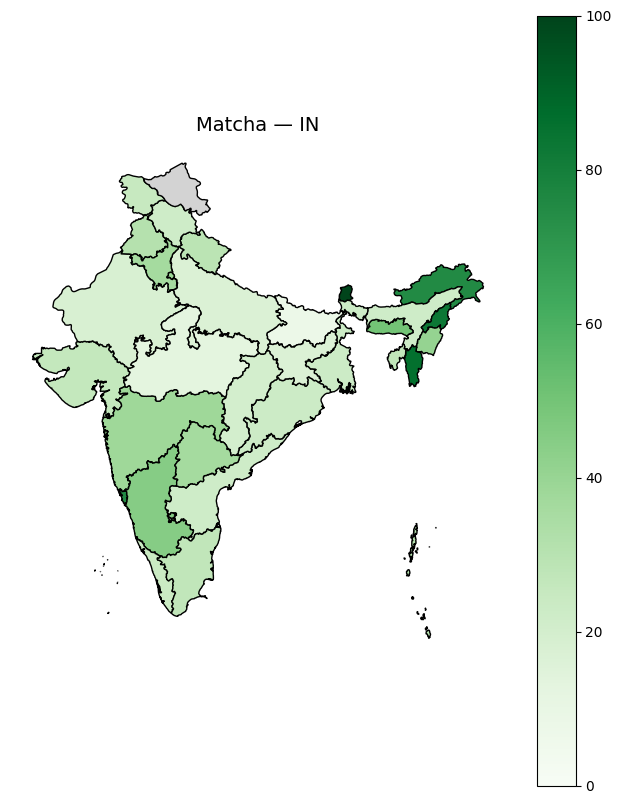

In [16]:
def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap='Greens',                     # 👈 changed to green color palette
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: plot matcha in India
plot_subnational_map('matcha', 'IN')


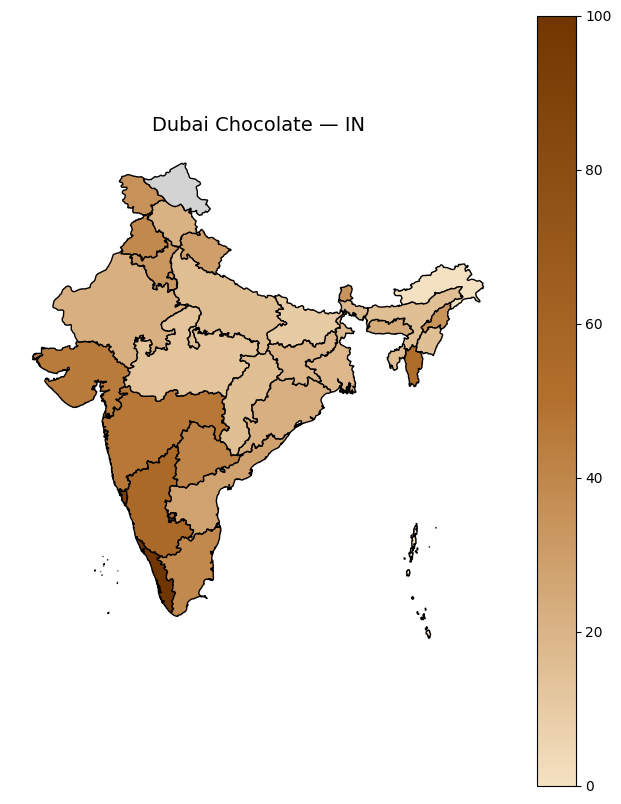

In [19]:
from matplotlib.colors import LinearSegmentedColormap

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom brown colormap based on your #713600 tone
    custom_brown = LinearSegmentedColormap.from_list(
        "custom_brown",
        ["#f4e1c1", "#b3702d", "#713600"]  # light beige → medium brown → dark #713600
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=custom_brown,                # 🍫 use custom brown shades
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Dubai Chocolate in India with #713600 color tone
plot_subnational_map('dubai_chocolate', 'IN')

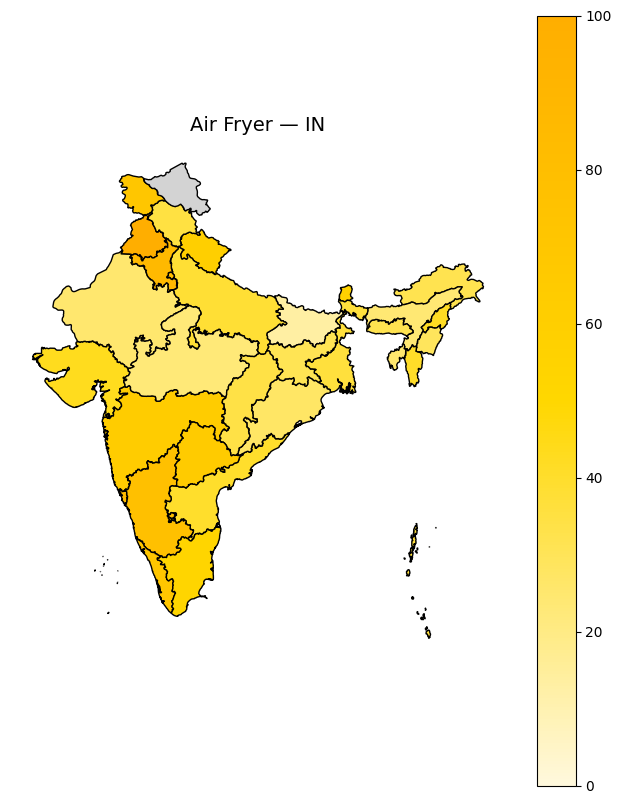

In [20]:
from matplotlib.colors import LinearSegmentedColormap

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom yellow gradient colormap
    yellow_cmap = LinearSegmentedColormap.from_list(
        "custom_yellow",
        ["#fff8dc", "#ffd700", "#ffae00"]  # light cream → golden → deep amber
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=yellow_cmap,                # 💛 yellow gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Air Fryer in India (yellow shades)
plot_subnational_map('air_fryer', 'IN')

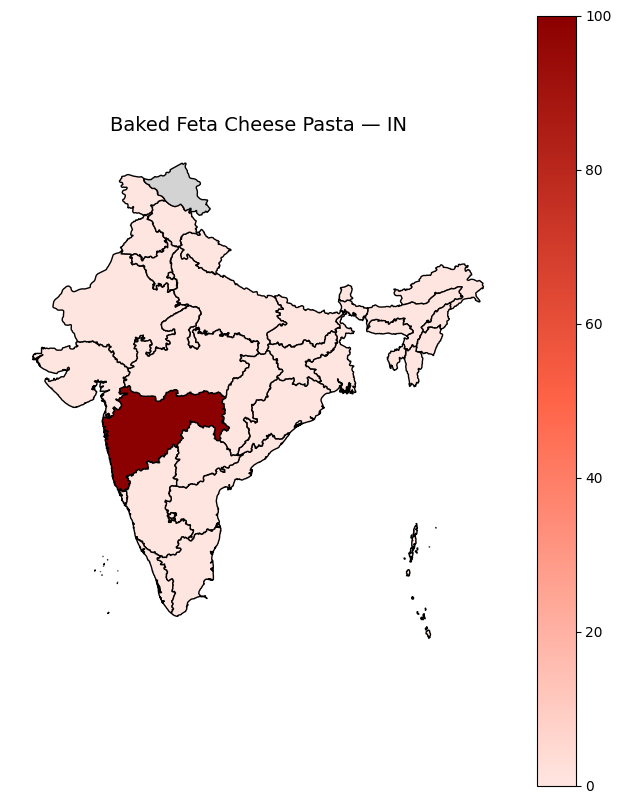

In [21]:
from matplotlib.colors import LinearSegmentedColormap

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom red gradient colormap (baked pasta feel)
    red_cmap = LinearSegmentedColormap.from_list(
        "baked_pasta_red",
        ["#ffe5e0", "#ff6347", "#8b0000"]  # light coral → tomato red → dark crimson
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=red_cmap,                    # 🍅 red gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Baked Feta Cheese Pasta in India (red shades)
plot_subnational_map('baked_feta_cheese_pasta', 'IN')


# **US Trends**

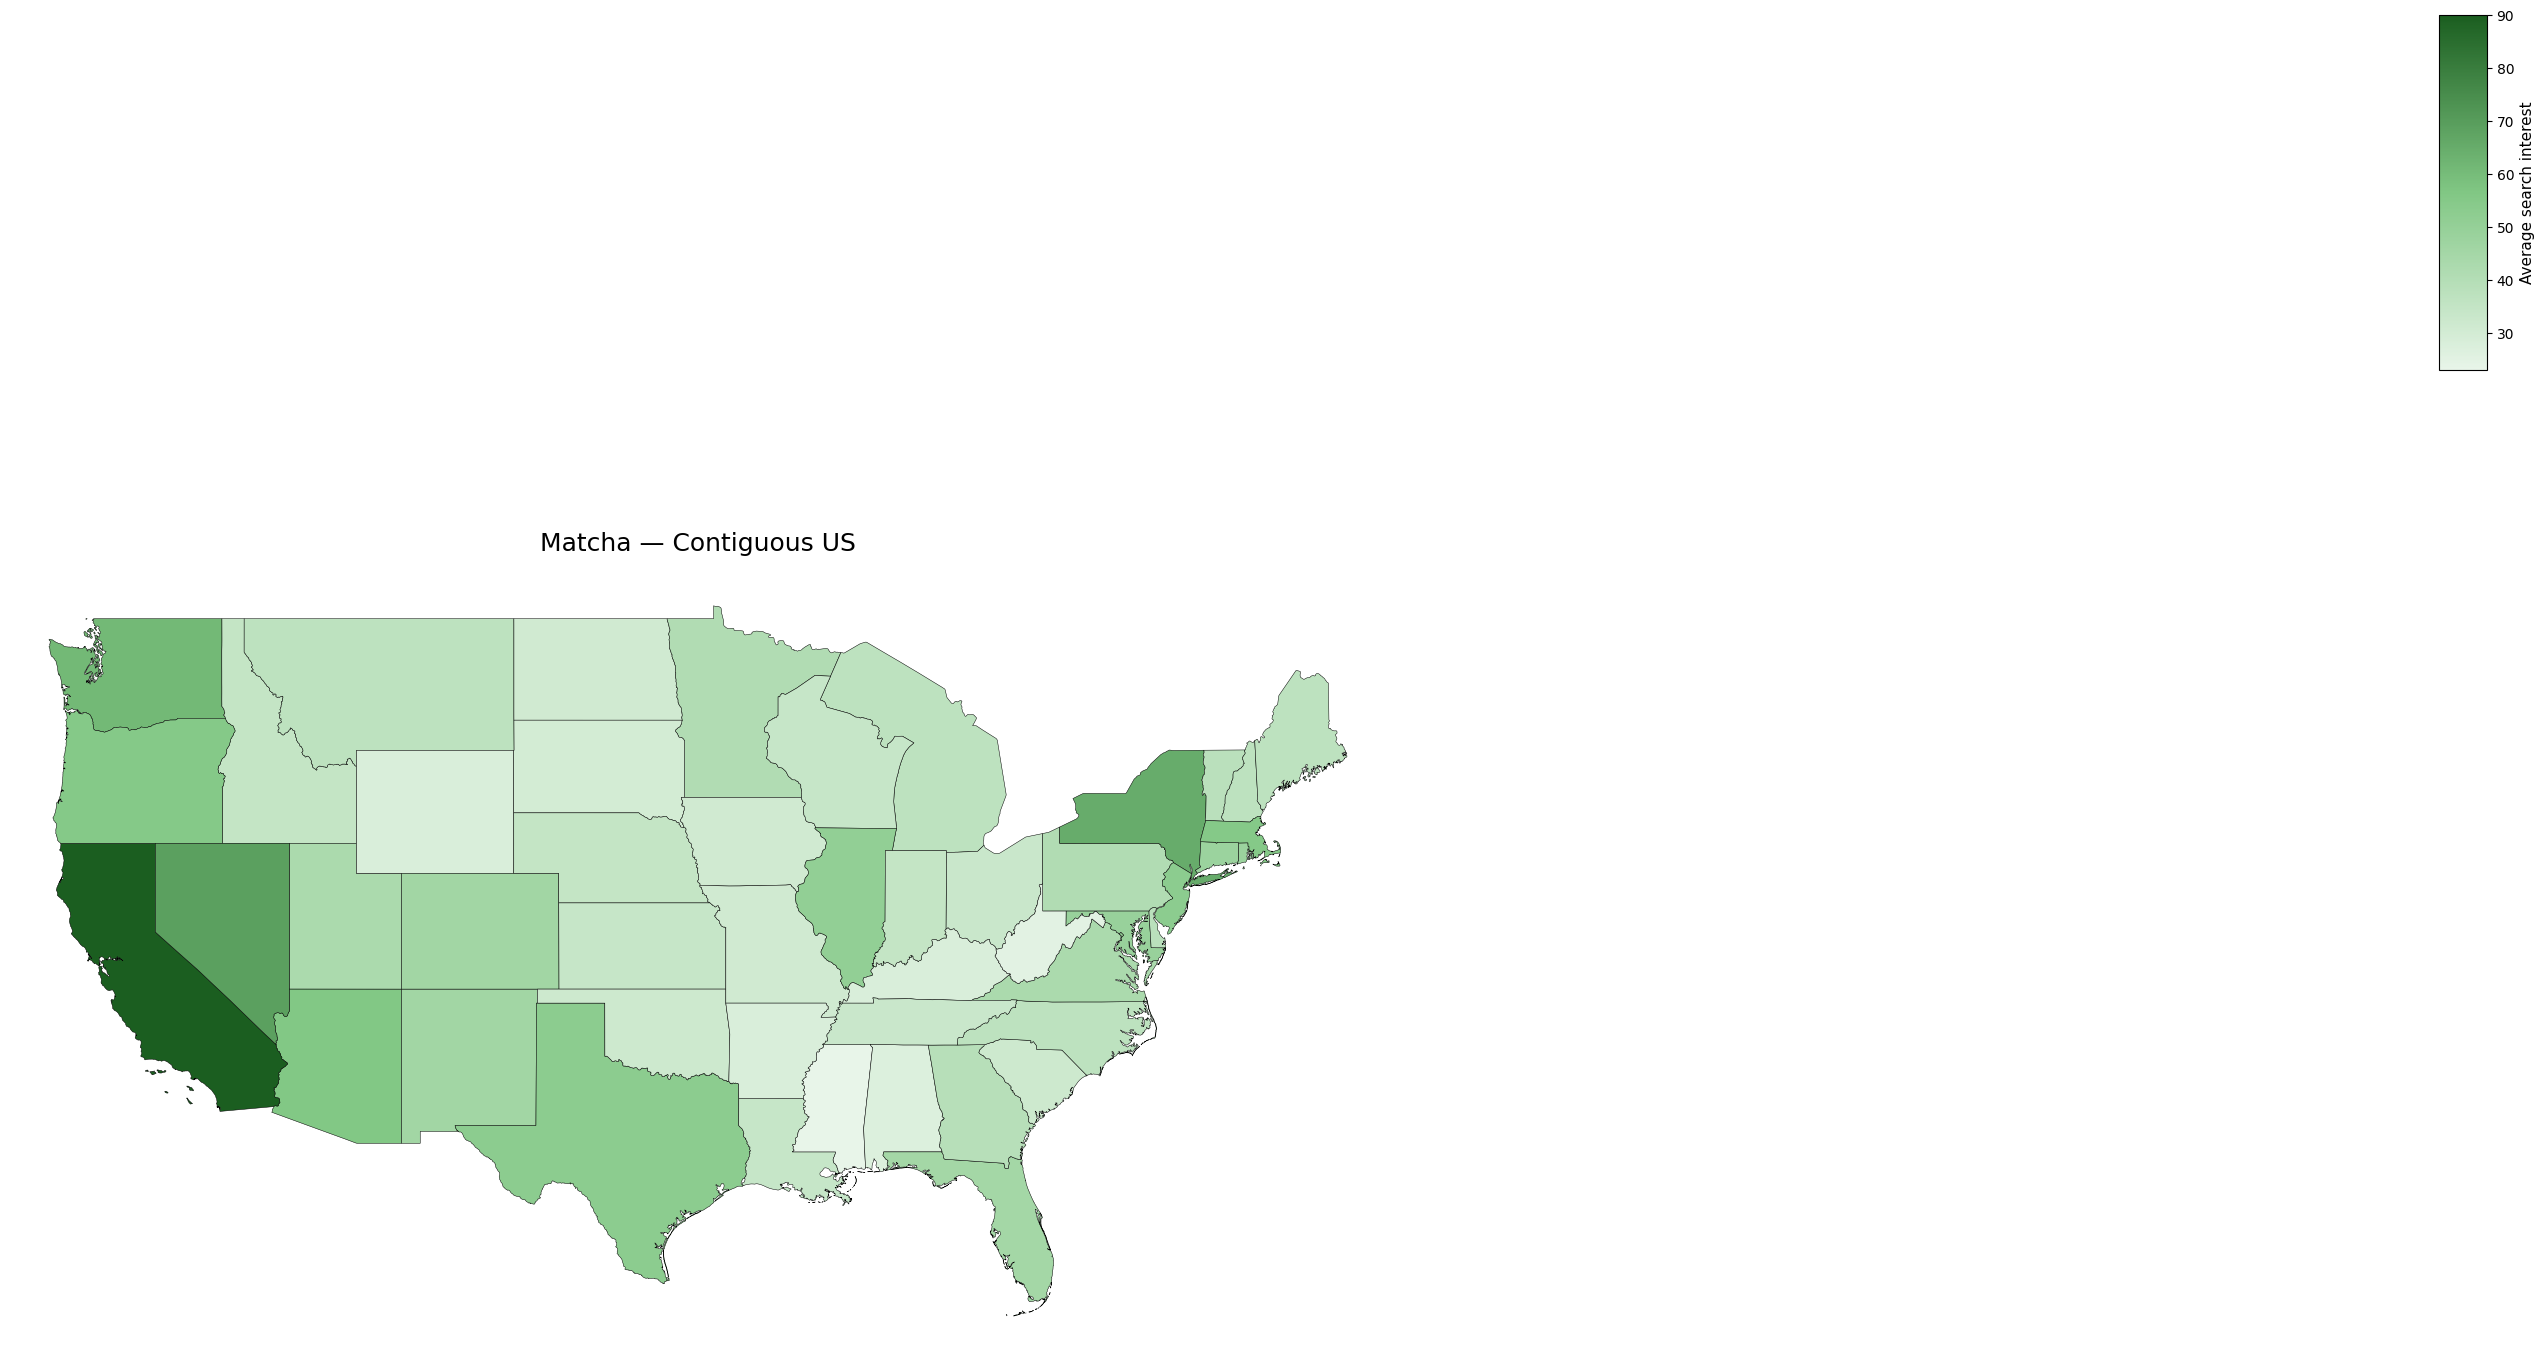

In [31]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

def plot_subnational_map_contiguous_us(kw, iso2='US', figsize=(16,10), cmap=None,
                                       exclude_iso2_suffixes=None, pad_frac=0.03):
    if cmap is None:
        cmap = LinearSegmentedColormap.from_list("matcha_green", ["#e8f5e9", "#81c784", "#1b5e20"])

    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if 'value_mean' not in gdf.columns or gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # exclude non-contiguous areas
    default_excludes = ['AK','HI','PR','GU','MP','VI','AS']
    if exclude_iso2_suffixes is None:
        exclude_iso2_suffixes = default_excludes

    working = gdf.copy()
    if 'iso_3166_2' in working.columns:
        working['reg_code'] = working['iso_3166_2'].astype(str).str.split('-').str[-1].str.upper().fillna('')
    else:
        working['reg_code'] = ''

    exclude_mask = working['reg_code'].isin(exclude_iso2_suffixes)
    contiguous = working.loc[~exclude_mask].copy()

    contiguous = contiguous.set_crs(epsg=4326, allow_override=True)
    contiguous_proj = contiguous.to_crs(epsg=3857)

    vals = pd.to_numeric(contiguous_proj['value_mean'], errors='coerce').dropna()
    vmin, vmax = float(vals.min()), float(vals.max())
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.03, 0.03, 0.86, 0.94])
    contiguous_proj.plot(column='value_mean', ax=ax, cmap=cmap, norm=norm,
                         edgecolor='black', linewidth=0.35,
                         missing_kwds={"color":"lightgrey"})

    # tight bounds
    minx, miny, maxx, maxy = contiguous_proj.total_bounds
    dx, dy = maxx-minx, maxy-miny
    pad = max(dx,dy) * pad_frac
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.set_aspect('equal')
    ax.set_title(f"{kw.replace('_',' ').title()} — Contiguous US", fontsize=18, pad=12)
    ax.axis('off')

    # ✅ move legend closer to map
    cax = inset_axes(ax,
                     width="3.5%", height="45%",
                     loc='upper right',
                     bbox_to_anchor=(0.80, 0.70, 1, 1),  # ← pulled left/down
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("Average search interest", fontsize=11)

    plt.show()

# Example
plot_subnational_map_contiguous_us('matcha', 'US', figsize=(16,10))

# **UK Trends**

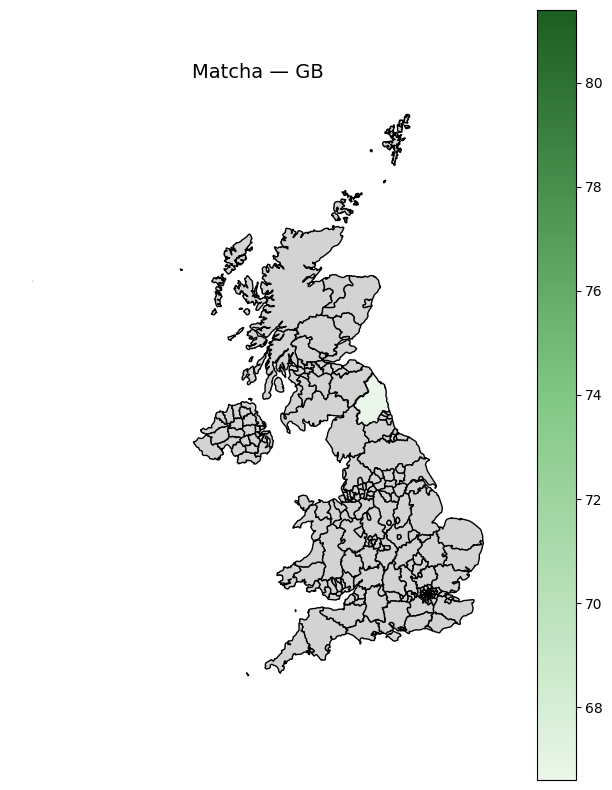

In [33]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map_matcha_uk(kw='matcha', iso2='GB', vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Custom matcha / green gradient (light mint -> matcha -> deep forest)
    matcha_cmap = LinearSegmentedColormap.from_list(
        "matcha_green",
        ["#eaf6e9", "#81c784", "#1b5e20"]   # light -> medium -> deep green
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=matcha_cmap,                 # 🍵 green gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Matcha in UK (green shades)
plot_subnational_map_matcha_uk()

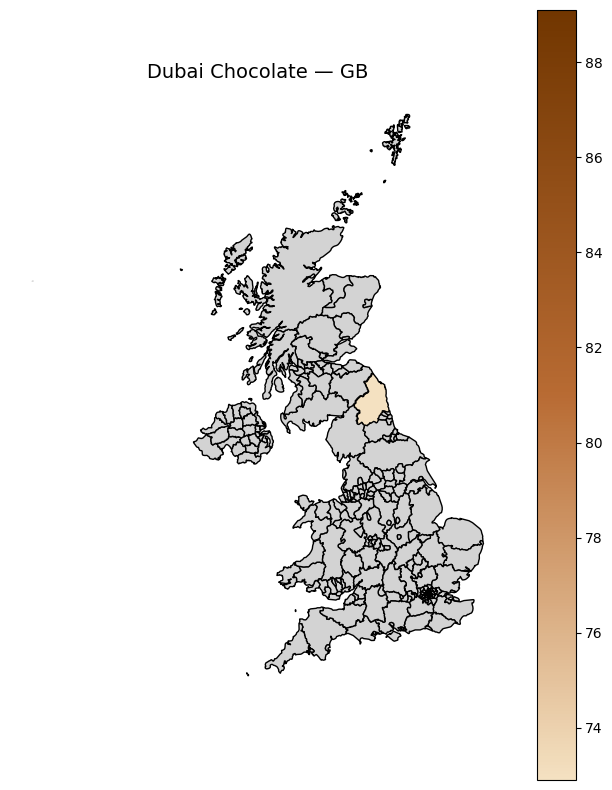

In [36]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom brown gradient colormap (based on #713600)
    brown_cmap = LinearSegmentedColormap.from_list(
        "chocolate_brown",
        ["#f4e1c1", "#b86b33", "#713600"]  # light mocha → milk chocolate → deep brown (#713600)
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=brown_cmap,                   # 🍫 brown gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Dubai Chocolate in UK (brown shades)
plot_subnational_map('dubai_chocolate', 'GB')

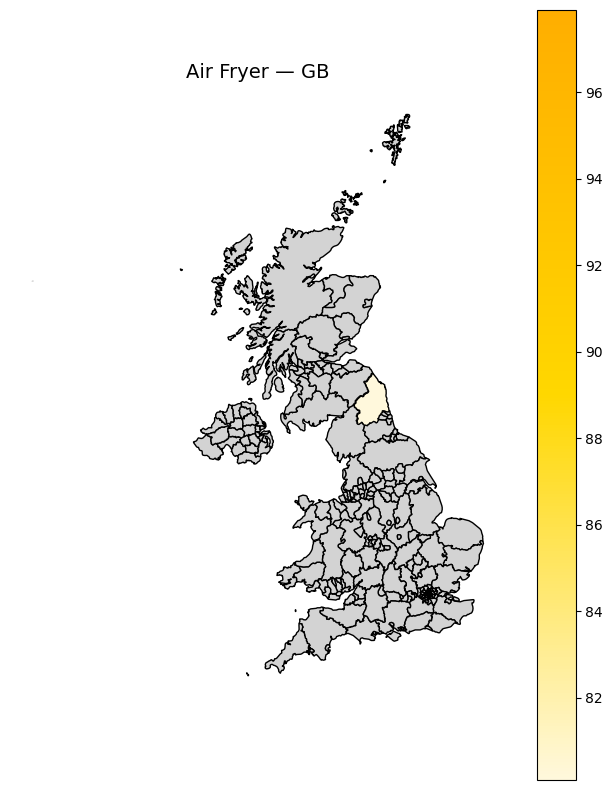

In [37]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom yellow gradient colormap (air fryer feel)
    yellow_cmap = LinearSegmentedColormap.from_list(
        "air_fryer_yellow",
        ["#fff8dc", "#ffd700", "#ffae00"]  # light cream → golden → deep amber
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=yellow_cmap,                  # 💛 yellow gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Air Fryer in UK (yellow shades)
plot_subnational_map('air_fryer', 'GB')

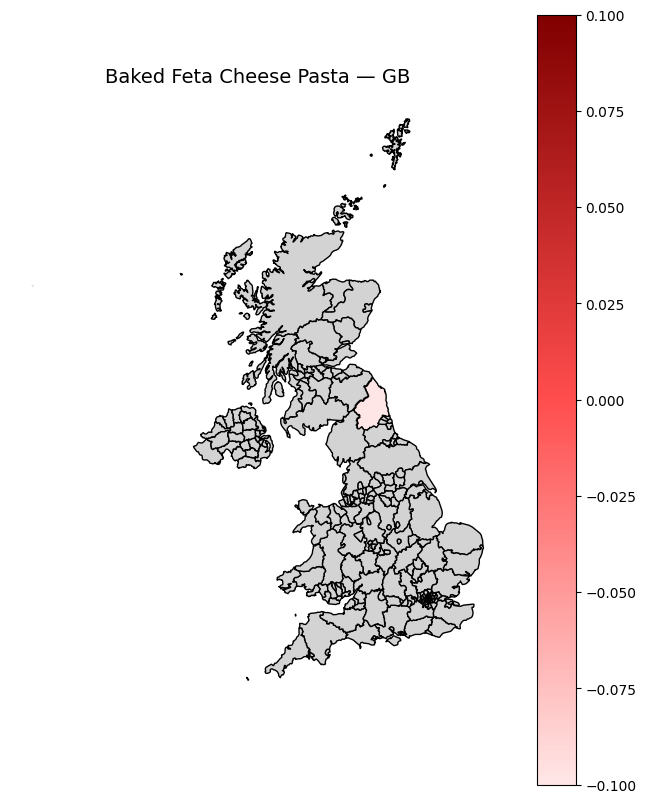

In [39]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom red gradient colormap (baked feta cheese pasta feel)
    red_cmap = LinearSegmentedColormap.from_list(
        "baked_feta_red",
        ["#ffe6e6", "#ff4d4d", "#800000"]  # light rose → tomato → deep crimson
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=red_cmap,                     # 🍅 red gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Baked Feta Cheese Pasta in United Kingdom (red shades)
plot_subnational_map('baked_feta_cheese_pasta', 'GB')

# **UAE Trends**

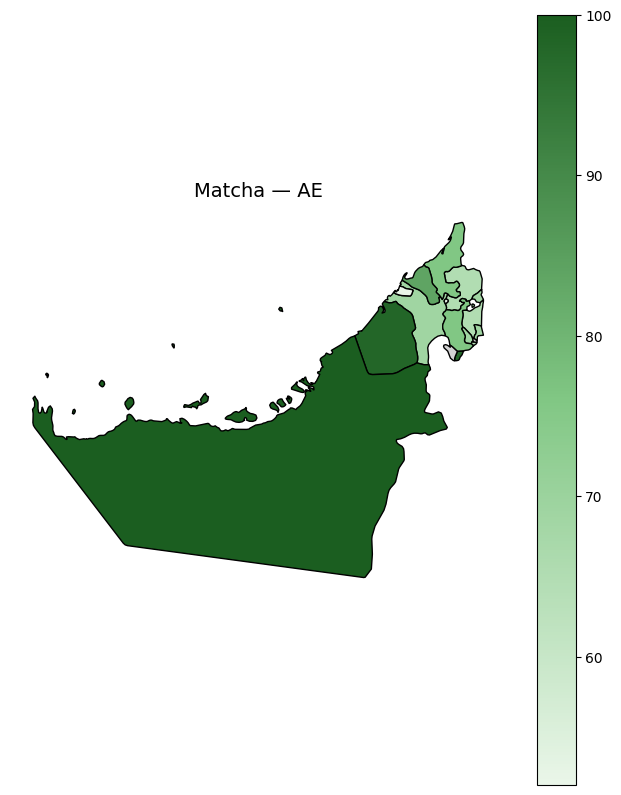

In [40]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom green gradient colormap (matcha feel)
    green_cmap = LinearSegmentedColormap.from_list(
        "matcha_green",
        ["#eaf6e9", "#81c784", "#1b5e20"]  # light mint → matcha → deep forest green
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=green_cmap,                 # 🍵 green gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Matcha in United Arab Emirates (green shades)
plot_subnational_map('matcha', 'AE')

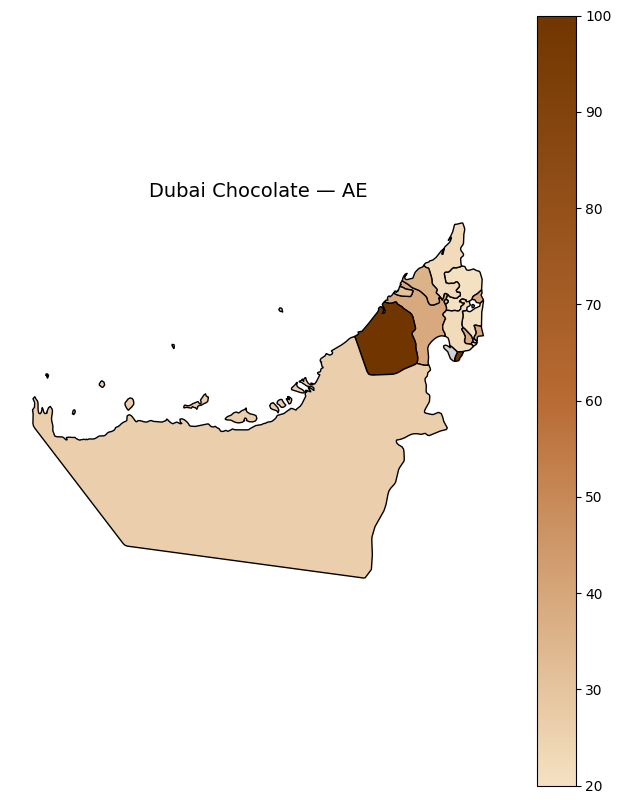

In [41]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom brown gradient colormap (based on #713600)
    brown_cmap = LinearSegmentedColormap.from_list(
        "dubai_chocolate_brown",
        ["#f4e1c1", "#b86b33", "#713600"]  # light mocha → milk chocolate → dark brown (#713600)
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=brown_cmap,                   # 🍫 brown gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Dubai Chocolate in United Arab Emirates (brown shades)
plot_subnational_map('dubai_chocolate', 'AE')

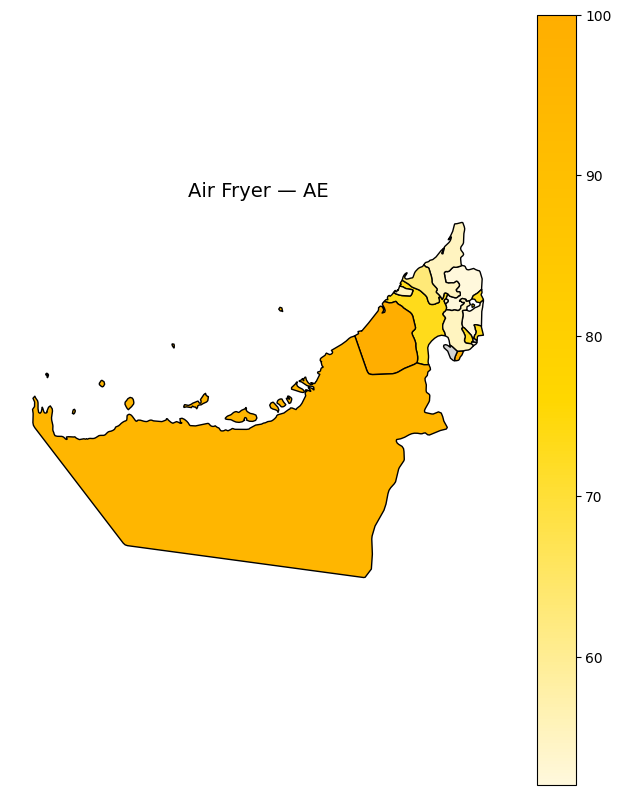

In [42]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom yellow gradient colormap (air fryer feel)
    yellow_cmap = LinearSegmentedColormap.from_list(
        "air_fryer_yellow",
        ["#fff8dc", "#ffd700", "#ffae00"]  # light cream → golden yellow → deep amber
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=yellow_cmap,                  # 💛 yellow gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Air Fryer in United Arab Emirates (yellow shades)
plot_subnational_map('air_fryer', 'AE')

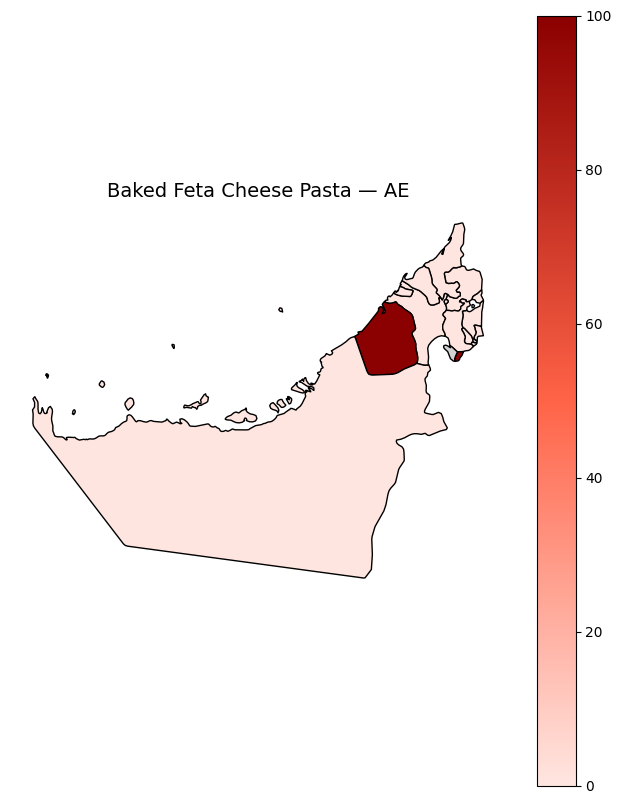

In [43]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom red gradient colormap (baked feta pasta feel)
    red_cmap = LinearSegmentedColormap.from_list(
        "baked_feta_red",
        ["#ffe5e0", "#ff6347", "#8b0000"]  # light coral → tomato red → dark crimson
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=red_cmap,                     # 🍅 red gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Baked Feta Cheese Pasta in United Arab Emirates (red shades)
plot_subnational_map('baked_feta_cheese_pasta', 'AE')

# **South Korea Trends**

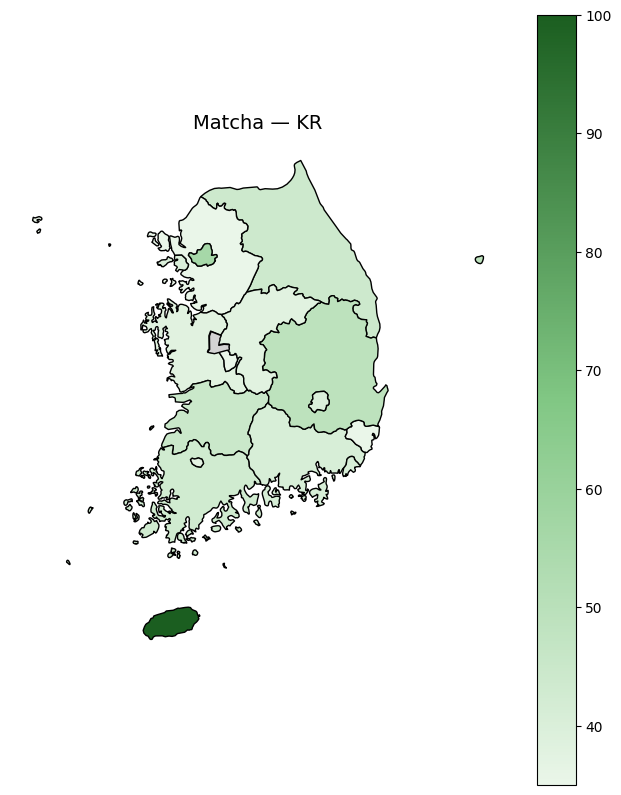

In [44]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom green gradient colormap (matcha feel)
    green_cmap = LinearSegmentedColormap.from_list(
        "matcha_green",
        ["#eaf6e9", "#81c784", "#1b5e20"]  # light mint → matcha → deep forest green
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=green_cmap,                  # 🍵 green gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Matcha in South Korea (green shades)
plot_subnational_map('matcha', 'KR')

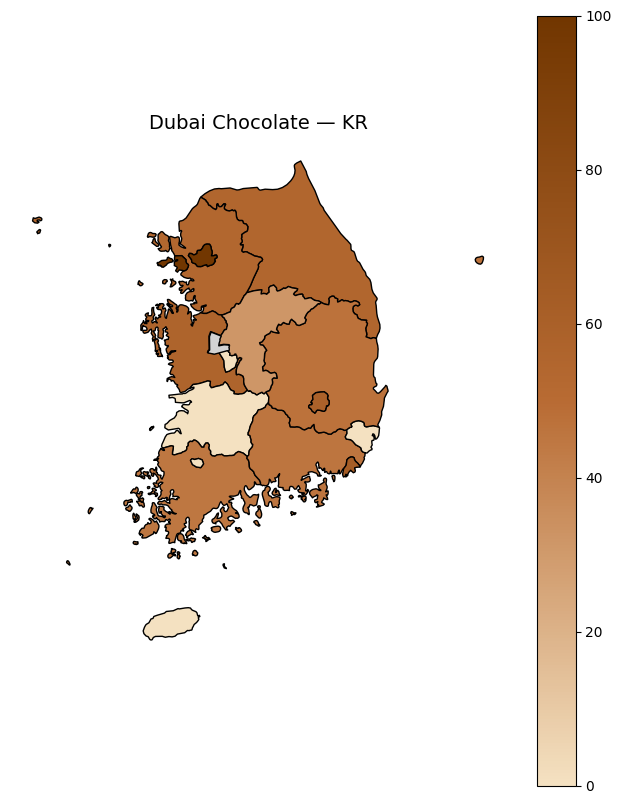

In [45]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom brown gradient colormap (based on #713600)
    brown_cmap = LinearSegmentedColormap.from_list(
        "dubai_chocolate_brown",
        ["#f4e1c1", "#b86b33", "#713600"]  # light mocha → milk chocolate → dark brown (#713600)
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=brown_cmap,                  # 🍫 brown gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Dubai Chocolate in South Korea (brown shades)
plot_subnational_map('dubai_chocolate', 'KR')

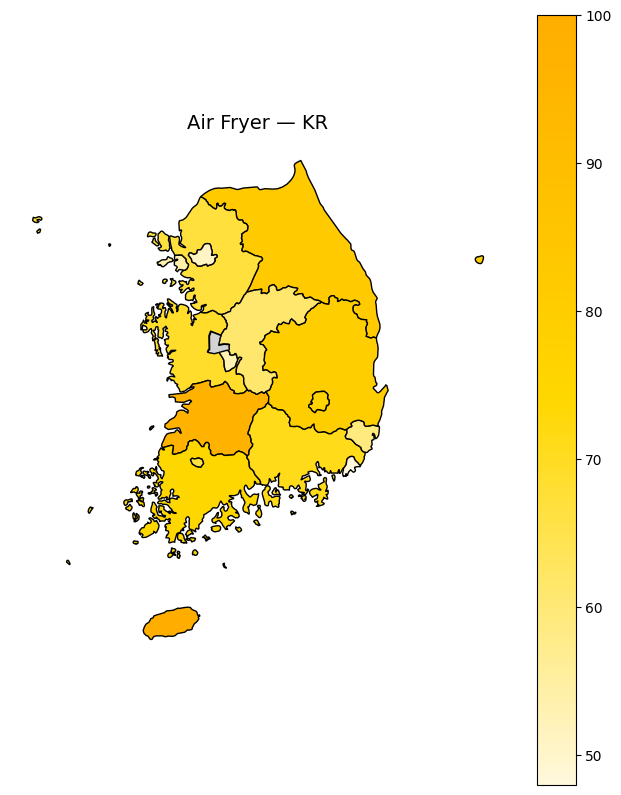

In [46]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom yellow gradient colormap (air fryer feel)
    yellow_cmap = LinearSegmentedColormap.from_list(
        "air_fryer_yellow",
        ["#fff8dc", "#ffd700", "#ffae00"]  # light cream → golden yellow → deep amber
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=yellow_cmap,                 # 💛 yellow gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Air Fryer in South Korea (yellow shades)
plot_subnational_map('air_fryer', 'KR')

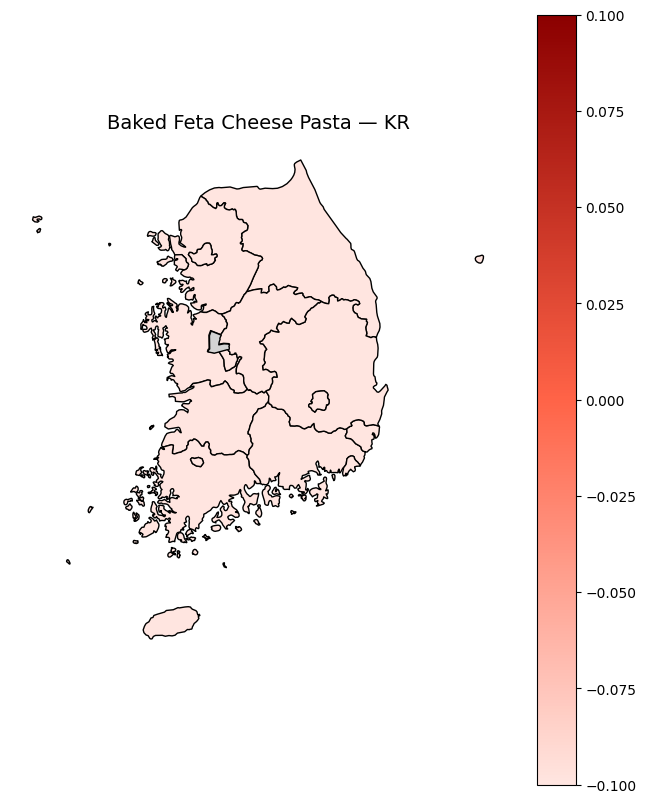

In [47]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def plot_subnational_map(kw, iso2, vmin=None, vmax=None):
    gdf = merged_dict.get((kw, iso2))
    if gdf is None:
        print(f"No subnational geometry for {kw} {iso2}.")
        return
    if gdf['value_mean'].dropna().empty:
        print(f"No region-level values found for {kw} {iso2}.")
        return

    # Create a custom red gradient colormap (baked feta pasta feel)
    red_cmap = LinearSegmentedColormap.from_list(
        "baked_feta_red",
        ["#ffe5e0", "#ff6347", "#8b0000"]  # light coral → tomato red → dark crimson
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    gdf.plot(
        column='value_mean',
        ax=ax,
        cmap=red_cmap,                     # 🍅 red gradient colormap
        edgecolor='black',
        missing_kwds={"color": "lightgrey"},
        legend=True,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"{kw.replace('_',' ').title()} — {iso2}", fontsize=14)
    ax.axis('off')
    plt.show()

# Example: Baked Feta Cheese Pasta in South Korea (red shades)
plot_subnational_map('baked_feta_cheese_pasta', 'KR')